In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.optim as optim
import torch.distributions as distributions

import numpy as np
import matplotlib.pyplot as plt

In [6]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
batch_size = 64
learning_rate = 1e-3
epochs=100

In [8]:
####################################
# STEP 1: Implement Coupling Layer #
####################################

class AbstractCoupling(nn.Module):
    def __init__(self, mask_config):
        super(AbstractCoupling, self).__init__()
        self.mask_config = mask_config

    def build_mask(self, size, config=1.):
        mask = np.arange(size).reshape(-1, 1) + np.arange(size)
        mask = np.mod(config + mask, 2)
        mask = mask.reshape(-1, 1, size, size) 
        return torch.tensor(mask.astype('float32'))

    def batch_stat(self, x):
        mean = torch.mean(x, dim=(0, 2, 3), keepdim=True)
        var = torch.mean((x - mean)**2, dim=(0, 2, 3), keepdim=True)
        return mean, var


class CheckerboardAffineCoupling(AbstractCoupling):
    def __init__(self, in_out_dim, mid_dim, size, mask_config):

        super(CheckerboardAffineCoupling, self).__init__(mask_config)

        self.mask = self.build_mask(size, config=mask_config).cuda()
        self.scale = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.scale_shift = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.in_bn = nn.BatchNorm2d(in_out_dim)
        self.block = nn.Sequential(      
            nn.ReLU(),                   
            ResidualModule(in_out_dim, mid_dim, 2*in_out_dim))
        self.out_bn = nn.BatchNorm2d(in_out_dim, affine=False)

    def forward(self, x, reverse=False):
        [B, C, _, _] = list(x.size())
        mask = self.mask.repeat(B, 1, 1, 1)
        x_ = self.in_bn(x * mask)
        (shift, log_rescale) = self.block(x_).split(C, dim=1)
        log_rescale = self.scale * torch.tanh(log_rescale) + self.scale_shift
        shift = shift * (1. - mask)
        log_rescale = log_rescale * (1. - mask)
        
        log_diag_J = log_rescale
        
        if reverse:
            mean, var = self.out_bn.running_mean, self.out_bn.running_var
            mean = mean.reshape(-1, 1, 1, 1).transpose(0, 1)
            var = var.reshape(-1, 1, 1, 1).transpose(0, 1)
            x = x * torch.exp(0.5 * torch.log(var + 1e-5) * (1. - mask)) \
                + mean * (1. - mask)
            x = (x - shift) * torch.exp(-log_rescale)
        else:
            x = x * torch.exp(log_rescale) + shift
            if self.training:
                _, var = self.batch_stat(x)
            else:
                var = self.out_bn.running_var
                var = var.reshape(-1, 1, 1, 1).transpose(0, 1)
            x = self.out_bn(x) * (1. - mask) + x * mask
            log_diag_J = log_diag_J - 0.5 * torch.log(var + 1e-5) * (1. - mask) 
        return x, log_diag_J

class CheckerboardCoupling(nn.Module):
    def __init__(self, in_out_dim, mid_dim, size, mask_config):

        super(CheckerboardCoupling, self).__init__()

        self.coupling = CheckerboardAffineCoupling(
                in_out_dim, mid_dim, size, mask_config)

    def forward(self, x, reverse=False):
        return self.coupling(x, reverse)

class ChannelwiseAffineCoupling(AbstractCoupling):
    def __init__(self, in_out_dim, mid_dim, mask_config):
        super(ChannelwiseAffineCoupling, self).__init__(mask_config)

        self.scale = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.scale_shift = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.in_bn = nn.BatchNorm2d(in_out_dim//2)
        self.block = nn.Sequential(        # 1st half of resnet: shift
            nn.ReLU(),                    # 2nd half of resnet: log_rescale
            ResidualModule(in_out_dim//2, mid_dim, in_out_dim))
        self.out_bn = nn.BatchNorm2d(in_out_dim//2, affine=False)

    def forward(self, x, reverse=False):
        [_, C, _, _] = list(x.size())
        if self.mask_config:
            (on, off) = x.split(C//2, dim=1)
        else:
            (off, on) = x.split(C//2, dim=1)
        off_ = self.in_bn(off)
        out = self.block(off_)
        (shift, log_rescale) = out.split(C//2, dim=1)
        log_rescale = self.scale * torch.tanh(log_rescale) + self.scale_shift
        
        log_diag_J = log_rescale
        if reverse:
            mean, var = self.out_bn.running_mean, self.out_bn.running_var
            mean = mean.reshape(-1, 1, 1, 1).transpose(0, 1)
            var = var.reshape(-1, 1, 1, 1).transpose(0, 1)
            on = on * torch.exp(0.5 * torch.log(var + 1e-5)) + mean
            on = (on - shift) * torch.exp(-log_rescale)
        else:
            on = on * torch.exp(log_rescale) + shift
            if self.training:
                _, var = self.batch_stat(on)
            else:
                var = self.out_bn.running_var
                var = var.reshape(-1, 1, 1, 1).transpose(0, 1)
            on = self.out_bn(on)
            log_diag_J = log_diag_J - 0.5 * torch.log(var + 1e-5)
        if self.mask_config:
            x = torch.cat((on, off), dim=1)
            log_diag_J = torch.cat((log_diag_J, torch.zeros_like(log_diag_J)), 
                dim=1)
        else:
            x = torch.cat((off, on), dim=1)
            log_diag_J = torch.cat((torch.zeros_like(log_diag_J), log_diag_J), 
                dim=1)
        return x, log_diag_J

class ChannelwiseCoupling(nn.Module):
    def __init__(self, in_out_dim, mid_dim, mask_config):
        """
        in_out_dim: number of input and output features.
        mid_dim: number of features in residual blocks.
        mask_config: 1 if change the top half, 0 if change the bottom half.
        """
        super(ChannelwiseCoupling, self).__init__()

        self.coupling = ChannelwiseAffineCoupling(in_out_dim, mid_dim, mask_config)

    def forward(self, x, reverse=False):
        return self.coupling(x, reverse)

In [9]:
############################
# STEP 2: Implement ResNet #
############################

class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super(ResidualBlock, self).__init__()
        self.res_block = nn.Sequential(
            nn.BatchNorm2d(dim),
            nn.ReLU(),
            nn.Conv2d(dim, dim, (3,3), stride=1, padding=1, bias=False),
            nn.BatchNorm2d(dim),
            nn.ReLU(),
            nn.Conv2d(dim, dim, (3,3), stride=1, padding=1, bias=True))

    def forward(self, x):
        return x + self.res_block(x)

class ResidualModule(nn.Module):
    def __init__(self, in_dim, dim, out_dim):

        super(ResidualModule, self).__init__()
        
        self.in_block = nn.Sequential(
            nn.Conv2d(in_dim, dim, (3, 3), stride=1, padding=1, bias=True),
            nn.Conv2d(dim, dim, (1, 1), stride=1, padding=0, bias=True))
        self.in_skip = nn.Conv2d(dim, dim, (1, 1), stride=1, padding=0, bias=True)

        self.core_block = nn.ModuleList(
            [ResidualBlock(dim) for _ in range(8)])
        self.core_skips = nn.ModuleList(
            [nn.Conv2d(dim, dim, (1, 1), stride=1, padding=0, bias=True) 
            for _ in range(8)])
        
        self.out_block = nn.Sequential(
            nn.BatchNorm2d(dim),
            nn.ReLU(),
            nn.Conv2d(dim, out_dim, (1, 1), stride=1, padding=0, bias=True))

    def forward(self, x):
        x = self.in_block(x)
        out = self.in_skip(x)
        for i in range(len(self.core_block)):
            x = self.core_block[i](x)
            out = out + self.core_skips[i](x)
        x = out
        return self.out_block(x)

In [10]:
#############################
# STEP 3: Implement RealNVP #
#############################
class RealNVP(nn.Module):
    def __init__(self):
        super(RealNVP, self).__init__()
        self.prior = distributions.Normal(torch.tensor(0.).to(device), torch.tensor(1.).to(device))

        chan = 3
        size = 32
        dim = 64

        self.checkerboard_coupling_1 = self.checkerboard_combo(chan, dim, size)
        self.channelwise_coupling = self.channelwise_combo(chan*4, dim)
        self.order_matrix_1 = self.order_matrix(chan).cuda()
        chan *= 2
        size //= 2

        self.checkerboard_coupling_2 = self.checkerboard_combo(chan, dim, size, final=True)

    def checkerboard_combo(self, in_out_dim, mid_dim, size, final=False):
        """
        in_out_dim: number of input and output features.
        mid_dim: number of features in residual blocks.
        size: height/width of features.
        final: True if at final scale, False otherwise.
        """
        if final:
            return nn.ModuleList([
                CheckerboardCoupling(in_out_dim, mid_dim, size, 1.),
                CheckerboardCoupling(in_out_dim, mid_dim, size, 0.),
                CheckerboardCoupling(in_out_dim, mid_dim, size, 1.),
                CheckerboardCoupling(in_out_dim, mid_dim, size, 0.)])
        else:
            return nn.ModuleList([
                CheckerboardCoupling(in_out_dim, mid_dim, size, 1.), 
                CheckerboardCoupling(in_out_dim, mid_dim, size, 0.),
                CheckerboardCoupling(in_out_dim, mid_dim, size, 1.)])
        
    def channelwise_combo(self, in_out_dim, mid_dim):
        """
        in_out_dim: number of input and output features.
        mid_dim: number of features in residual blocks.
        """
        return nn.ModuleList([
                ChannelwiseCoupling(in_out_dim, mid_dim, 0.),
                ChannelwiseCoupling(in_out_dim, mid_dim, 1.),
                ChannelwiseCoupling(in_out_dim, mid_dim, 0.)])

    def squeeze(self, x):
        """
        Squeezes a C x H x W tensor into a 4C x H/2 x W/2 tensor.
        """
        [B, C, H, W] = list(x.size())
        x = x.reshape(B, C, H//2, 2, W//2, 2)
        x = x.permute(0, 1, 3, 5, 2, 4)
        x = x.reshape(B, C*4, H//2, W//2)
        return x

    def unsqueeze(self, x):
        """
        unsqueezes a C x H x W tensor into a C/4 x 2H x 2W tensor.
        """
        [B, C, H, W] = list(x.size())
        x = x.reshape(B, C//4, 2, 2, H, W)
        x = x.permute(0, 1, 4, 2, 5, 3)
        x = x.reshape(B, C//4, H*2, W*2)
        return x

    def order_matrix(self, channel):
        weights = np.zeros((channel*4, channel, 2, 2))
        ordering = np.array([[[[1., 0.],
                               [0., 0.]]],
                             [[[0., 0.],
                               [0., 1.]]],
                             [[[0., 1.],
                               [0., 0.]]],
                             [[[0., 0.],
                               [1., 0.]]]])
        for i in range(channel):
            s1 = slice(i, i+1)
            s2 = slice(4*i, 4*(i+1))
            weights[s2, s1, :, :] = ordering
        shuffle = np.array([4*i for i in range(channel)]
                         + [4*i+1 for i in range(channel)]
                         + [4*i+2 for i in range(channel)]
                         + [4*i+3 for i in range(channel)])
        weights = weights[shuffle, :, :, :].astype('float32')
        return torch.tensor(weights)

    def factor_out(self, x, order_matrix):
        """Downscales and factors out the bottom half of the tensor.
        
        Args:
            x: input tensor (B x C x H x W).
            order_matrix: a kernel that defines the ordering of variables.
        Returns:
            the top half for further transformation (B x 2C x H/2 x W/2)
            and the Gaussianized bottom half (B x 2C x H/2 x W/2).
        """
        x = F.conv2d(x, order_matrix, stride=2, padding=0)
        [_, C, _, _] = list(x.size())
        (on, off) = x.split(C//2, dim=1)
        return on, off

    def restore(self, on, off, order_matrix):
        """Merges variables and restores their ordering.

        Args:
            on: the active (transformed) variables (B x C x H x W).
            off: the inactive variables (B x C x H x W).
            order_matrix: a kernel that defines the ordering of variables.
        Returns:
            combined variables (B x 2C x H x W).
        """
        x = torch.cat((on, off), dim=1)        
        return F.conv_transpose2d(x, order_matrix, stride=2, padding=0)

    def g(self, z):
        """
        Transformation g: Z -> X (inverse of f).
        """
        x, x_off_1 = self.factor_out(z, self.order_matrix_1)

        for i in reversed(range(len(self.checkerboard_coupling_2))):
            x, _ = self.checkerboard_coupling_2[i](x, reverse=True)

        x = self.restore(x, x_off_1, self.order_matrix_1)

        x = self.squeeze(x)
        for i in reversed(range(len(self.channelwise_coupling))):
            x, _ = self.channelwise_coupling[i](x, reverse=True)
        x = self.unsqueeze(x)

        for i in reversed(range(len(self.checkerboard_coupling_1))):
            x, _ = self.checkerboard_coupling_1[i](x, reverse=True)            
        return x

    def f(self, x):
        """
        Transformation f: X -> Z (inverse of g).
        """
        z, log_diag_J = x, torch.zeros_like(x)

        for i in range(len(self.checkerboard_coupling_1)):
            z, inc = self.checkerboard_coupling_1[i](z)
            log_diag_J = log_diag_J + inc

        z, log_diag_J = self.squeeze(z), self.squeeze(log_diag_J)
        # print(z.shape) (B, 12, 16, 16)
        for i in range(len(self.channelwise_coupling)):
            z, inc = self.channelwise_coupling[i](z)
            log_diag_J = log_diag_J + inc
        z, log_diag_J = self.unsqueeze(z), self.unsqueeze(log_diag_J)
        # print(z.shape) (B, 3, 32, 32)

        z, z_off_1 = self.factor_out(z, self.order_matrix_1)
        log_diag_J, log_diag_J_off_1 = self.factor_out(log_diag_J, self.order_matrix_1)

        for i in range(len(self.checkerboard_coupling_2)):
            z, inc = self.checkerboard_coupling_2[i](z)
            log_diag_J = log_diag_J + inc
        
        z = self.restore(z, z_off_1, self.order_matrix_1)
        log_diag_J = self.restore(log_diag_J, log_diag_J_off_1, self.order_matrix_1)
        return z, log_diag_J

    def log_prob(self, x):
        """
        Computes data log-likelihood.
        """
        z, log_diag_J = self.f(x)
        log_det_J = torch.sum(log_diag_J, dim=(1, 2, 3))
        log_prior_prob = torch.sum(self.prior.log_prob(z), dim=(1, 2, 3))
        return log_prior_prob + log_det_J

    def sample(self, n_sample):
        """
        Generates samples
        """
        z = self.prior.sample((n_sample, 3, 32, 32))        
        return self.g(z)

    def forward(self, x):
        return self.log_prob(x)

In [11]:
#####################################################################
# STEP 4: Create DataLoader using only one label of CIFAR10 Dataset #
#####################################################################

def CIFAR10_subset(root, train, download, transform, target):
    CIFAR10 = datasets.CIFAR10(root=root, train=train, download=download, transform=transform)
    bool_targets = [idx==target for idx in CIFAR10.targets]
    index = [i for i, x in enumerate(bool_targets) if x]
    CIFAR10.data = [CIFAR10.data[idx] for idx in index]
    CIFAR10.targets = index
    return CIFAR10

train = CIFAR10_subset('./', True, True, transforms.Compose([transforms.RandomHorizontalFlip(p=0.5), transforms.ToTensor(), transforms.Resize((32,32))]), 7)
train_split, val_split = torch.utils.data.random_split(train, [4500, 500])

train_loader = torch.utils.data.DataLoader(train_split,
    batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_split,
    batch_size=batch_size, shuffle=False, num_workers=2)

# For preprocessing
def logit_transform(x, constraint=0.9, reverse=False):
    if reverse:
        x = 1. / (torch.exp(-x) + 1.)    # [0.05, 0.95]
        x *= 2.             # [0.1, 1.9]
        x -= 1.             # [-0.9, 0.9]
        x /= constraint     # [-1, 1]
        x += 1.             # [0, 2]
        x /= 2.             # [0, 1]
        return x, 0
    else:
        [B, C, H, W] = list(x.size())
        
        # dequantization
        noise = distributions.Uniform(0., 1.).sample((B, C, H, W))
        x = (x * 255. + noise) / 256.
        
        # restrict data
        x *= 2.             # [0, 2]
        x -= 1.             # [-1, 1]
        x *= constraint     # [-0.9, 0.9]
        x += 1.             # [0.1, 1.9]
        x /= 2.             # [0.05, 0.95]

        # logit data
        logit_x = torch.log(x) - torch.log(1. - x)

        # log-determinant of Jacobian from the transform
        pre_logit_scale = torch.tensor(
            np.log(constraint) - np.log(1. - constraint))
        log_diag_J = F.softplus(logit_x) + F.softplus(-logit_x) \
            - F.softplus(-pre_logit_scale)

        return logit_x, torch.sum(log_diag_J, dim=(1, 2, 3))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./


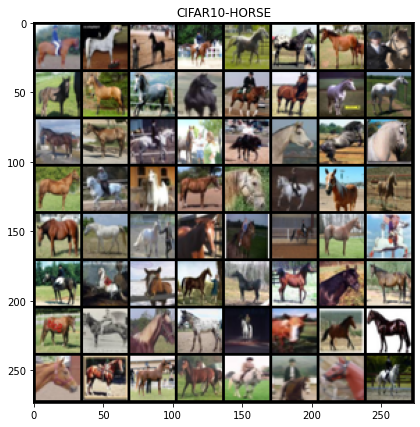

In [12]:
for image, _ in train_loader:
    plt.figure(figsize = (7,7))
    plt.title('CIFAR10-HORSE')
    plt.imshow(make_grid(image, normalize=True).permute(1,2,0))
    break

1th epoch, training loss mean:-3884.0147774924694
1th epoch, val loss mean:-3884.0147774924694
2th epoch, training loss mean:-5133.262715944102
2th epoch, val loss mean:-5133.262715944102
3th epoch, training loss mean:-5623.538876815581
3th epoch, val loss mean:-5623.538876815581
4th epoch, training loss mean:-5952.356555347711
4th epoch, val loss mean:-5952.356555347711
5th epoch, training loss mean:-6128.113927706866
5th epoch, val loss mean:-6128.113927706866
6th epoch, training loss mean:-6341.231073943662
6th epoch, val loss mean:-6341.231073943662
7th epoch, training loss mean:-6532.42753493618
7th epoch, val loss mean:-6532.42753493618
8th epoch, training loss mean:-6637.69951446963
8th epoch, val loss mean:-6637.69951446963
9th epoch, training loss mean:-6711.364814865757
9th epoch, val loss mean:-6711.364814865757
10th epoch, training loss mean:-6833.84003631162
10th epoch, val loss mean:-6833.84003631162
11th epoch, training loss mean:-6905.365234375
11th epoch, val loss mean

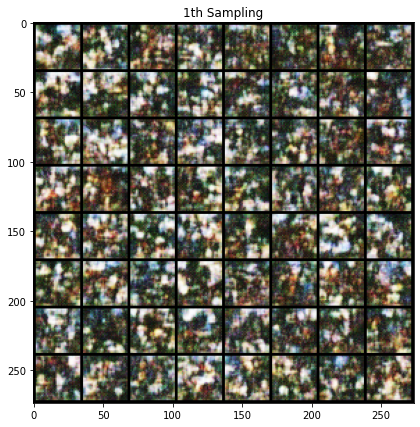

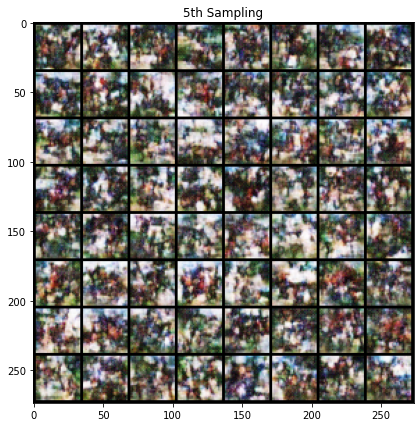

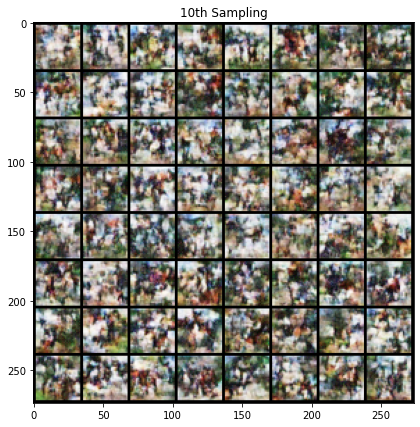

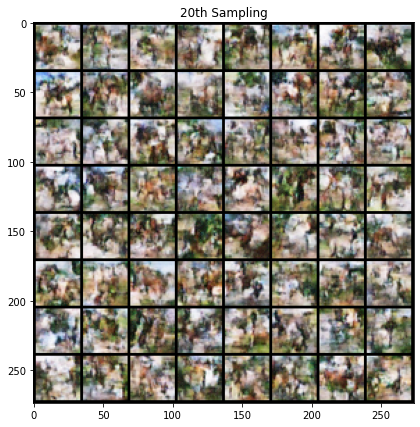

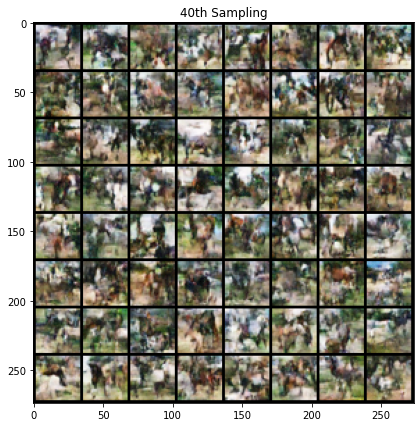

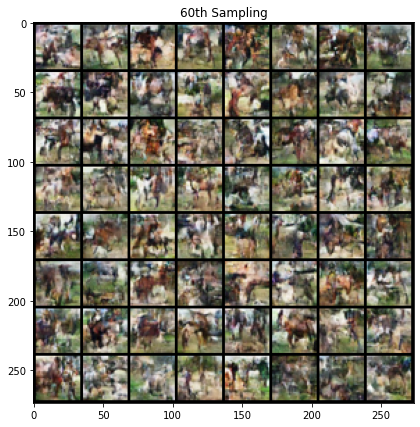

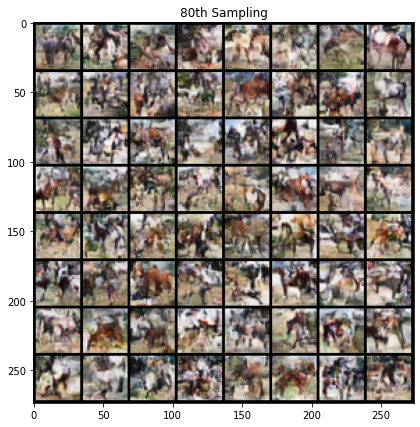

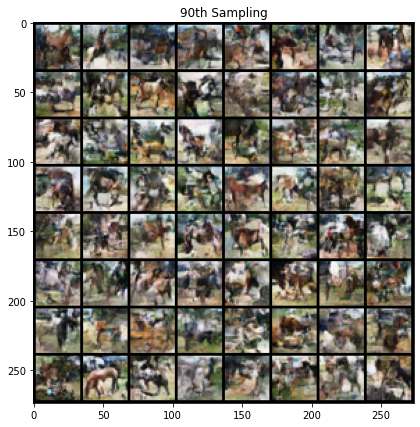

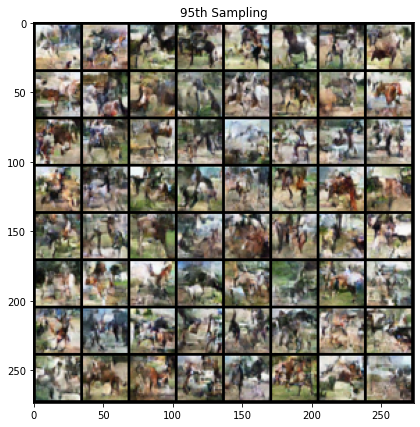

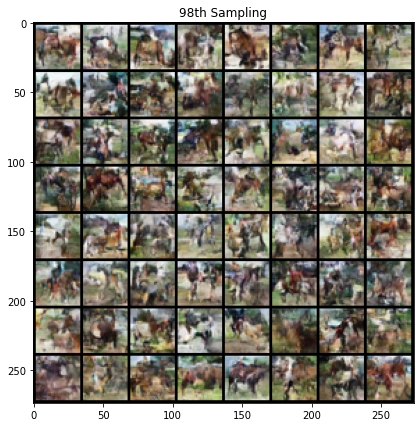

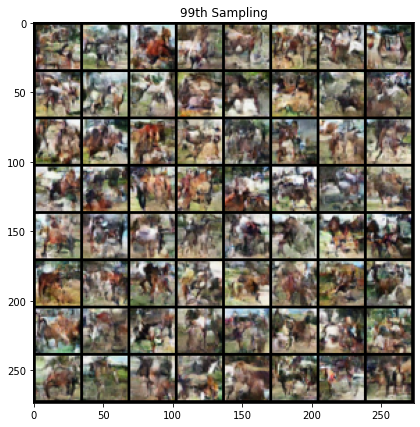

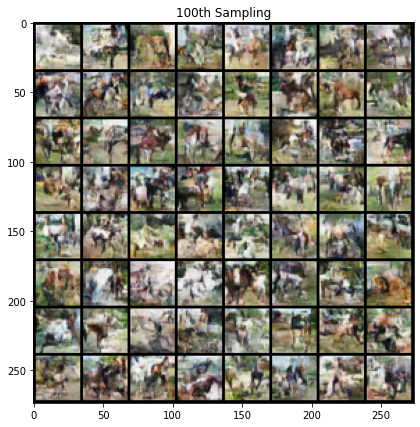

In [13]:
##############################
# STEP 5: Training the model #
##############################

flow = RealNVP().to(device)
optimizer = optim.Adamax(flow.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-7)

epoch = 0
for i in range(epochs):
    train_loss_mean = 0
    epoch += 1
    flow.train()
    for batch_idx, data in enumerate(train_loader, 1):
        optimizer.zero_grad()
        x, _ = data
        # log-determinant of Jacobian from the logit transform
        x, log_det = logit_transform(x)
        x = x.to(device)
        log_det = log_det.to(device)

        log_ll = flow(x)
        log_ll = (log_ll + log_det).mean()

        loss = -log_ll
        train_loss_mean += loss.item()

        loss.backward()
        optimizer.step()
    
    train_loss_mean = train_loss_mean / batch_idx
    print("{}th epoch, training loss mean:{}".format(epoch, train_loss_mean))

    # validation
    flow.eval()
    val_loss_mean = 0
    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader, 1):
            x, _ = data
            x, log_det = logit_transform(x)
            x = x.to(device)
            log_det = log_det.to(device)

            log_ll = flow(x)
            log_ll = (log_ll + log_det).mean()

            loss = -log_ll
            val_loss_mean += loss.item()
    
    val_loss_mean = val_loss_mean / batch_idx
    print("{}th epoch, val loss mean:{}".format(epoch, train_loss_mean))
    samples = flow.sample(batch_size)
    samples, _ = logit_transform(samples, reverse=True)
    save_image(samples, '{}th_epoch_output.png'.format(epoch))
    
    if epoch in [1,5,10,20,40,60,80,90,95,98,99,100]:
        plt.figure(figsize = (7,7))
        plt.title('{}th Sampling'.format(epoch))
        plt.imshow(make_grid(samples.cpu(), normalize=True).permute(1,2,0))